# cadCAD Tutorials: The Robot and the Marbles, part 7
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD. And [part 4](../robot-marbles-part-4/robot-marbles-part-4.ipynb) introduced Monte Carlo simulations.

In [part 6](../robot-marbles-part-4/robot-marbles-part-6.ipynb) we conducted A/B tests using different system initial conditions to see the differences.

In this notebook, we'll cover cadCAD's support for parameters and parameter sweeping, a useful feature to produce multiple configurations with different parameters. As in Part 6, let's start by copying the base configuration with which we ended Part 4. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__ and __non-deterministically__; at every timestep each robot acts with a probability P: 50% for robot 1 and 33.33% for robot 2.


__**We have added a new parameter in the `robot_arm` function called `capacity`. This is the amount of marbles a robot can move from one box to the other each time.**__

In [3]:
%%capture
from numpy.random import rand

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
sim_config_dict = {
    'T': range(10),
    'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
    #'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sH, s, capacity=1):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -capacity
    elif (s['box_A'] < s['box_B']):
        add_to_A = capacity
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, step, sH, s):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

def robot_arm_2(params, step, sH, s):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system



    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sH, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sH, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,         # returns a dict for the key-value pair
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,           # returns a tuple for the key-value pair 
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [4]:
%%capture
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

In [5]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['simulation', 'run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1            9      1       0
               2        1            8      2       0
               3        1            8      2       0
               4        1            8      2       0
...                                ...    ...     ...
           50  6        1            5      5       0
               7        1            5      5       0
               8        1            5      5       0
               9        1            5      5       0
               10       1            5      5       0

[550 rows x 3 columns]

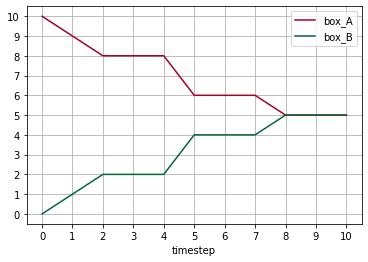

In [6]:
def print_plot(df,N):
    ax = None
    for i in range(N):
        ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                         grid=True,
                                         xticks=list(df['timestep'].drop_duplicates()), 
                                         yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                         legend = (ax == None),
                                         colormap = 'RdYlGn',
                                         ax = ax
                                      )
print_plot(df,sim_config_dict['N'])

## Parameters
What would happen if we "upgrade" the capacity of one of our robot arm to being able to move two marbles at once?

In order to test that, let's first redefine robot arms policies to get their capacity from the `params` parameter. That first `params` parameter is present in policy and state functions, and it makes reference to the dictionary of parameters of the system.

In [7]:
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, step, sH, s):
    params
    _robotId = 1
    capacity = params['capacity']['robot_1']
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s, capacity)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

def robot_arm_2(params, step, sH, s):
    _robotId = 2
    capacity = params['capacity']['robot_2']
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sH, s, capacity)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]

You may remember in previous tutorials we left the `M` key as an empty object and promised to use the parameters dictionary in further articles. This is the time. We set each arm's `capacity` here. Let's set the first robot arm capacity to 2 meanwhile we keep the second robot arm's capacity to 1.

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=50) and its duration will be of 10 timesteps
# `M` is a dictionary of parameters key in a future article. For now, let's leave it empty

sim_config_dict = {
    'T': range(10),
    'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
    'M': {
        'capacity': [
            {'robot_1': 2, 'robot_2': 1 }
        ]
    }
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

When using params, we recommend to use the multi_proc execution mode. Let's see what is the effect of having an "upgraded" arm over the system.

In [9]:
%%capture
from cadCAD import configs

del configs[:]

c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

exec_mode = ExecutionMode()
multi_mode_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_mode_ctx, configs=configs)

raw_result, tensor_field, sessions = run.execute()
result = pd.DataFrame(raw_result)

%matplotlib inline
import pandas as pd




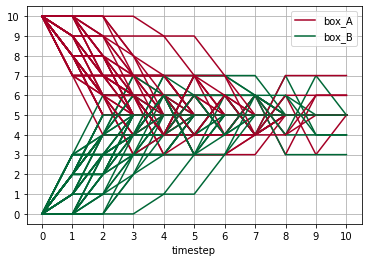

In [10]:
print_plot(result,sim_config_dict['N'])

## Parameter sweeping
In order to simulate more than one versions of the same system, we can create many `Configuration` objects to pass to the `Executor` instead of just one. For example, suppose we wanted to test the system under three different arm capacitiy configurations.

In [11]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We use `config_sim` to generate a list of configurations
from cadCAD.configuration.utils import config_sim

sim_config_dict = {
        'T': range(10),
        'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
        'M': {
            'capacity' : [
                { 'robot_1': 1, 'robot_2': 1 }, # Each robot has capacity 1
                { 'robot_1': 2, 'robot_2': 1 }, # Arm 1 has been "upgraded"
                { 'robot_1': 2, 'robot_2': 2 }  # Both arms have been "upgraded"
            ]
        }
    }

c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects. This time using the `append_configs` util for convenience. The configurations are stored in the `configs` list.

In [12]:
del configs[:]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(
    initial_state=genesis_states, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #dict containing simulation parameters
)

And now we can execute the simulation of those three different versions of the system in parallel.

In [17]:
exec_mode = ExecutionMode()
multi_mode_ctx = ExecutionContext(exec_mode.multi_mode)
executor = Executor(multi_mode_ctx, configs) # Pass an array configuration objects

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [18]:
%%capture


raw_result, tensor_field, sessions = executor.execute()
result = pd.DataFrame(raw_result)

In [19]:
sweeps = []
for i in result.subset.unique():
    sweeps.append(result[result['subset']==i])

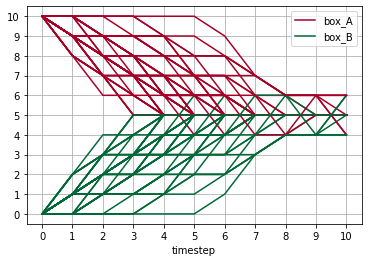

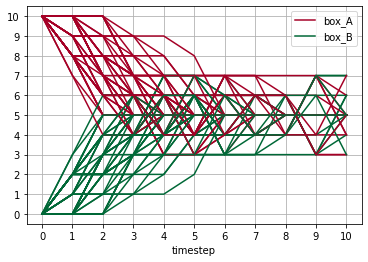

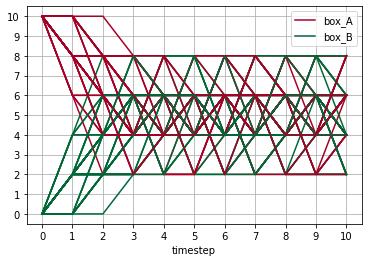

In [20]:
for i in sweeps:
    print_plot(i,sim_config_dict['N'])

Can you see the differences between the graphs? You probably can see setting higher capacities in robot arms make the the marbles in the boxes converge faster but have a loosened variation, meanwhile lower capacities make them converge slower but tighter.

As stated, parameters can be used to parametrize the states and policies, and we can run parallel simulations testing different parameters generating different configurations with `config_sim`.